In [1]:
import pandas as pd
import sqlite3
import glob

from IPython.display import Image, display
# import streamlit as st
from typing_extensions import TypedDict
from typing import Annotated

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langchain_ollama import ChatOllama
from langchain_core.messages import HumanMessage, AIMessage
from langchain.memory import ConversationBufferMemory
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate, FewShotPromptTemplate
from langchain.chains import create_sql_query_chain
from langchain_community.tools.sql_database.tool import QuerySQLDataBaseTool
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_community.utilities import SQLDatabase
from langchain_community.agent_toolkits.sql.toolkit import SQLDatabaseToolkit
from langgraph.prebuilt import create_react_agent
from sqlalchemy import create_engine
from pathlib import Path


In [2]:

# Load data to SQL with LangChain
def data_to_sql(df, name_of_database: str, data_path: str, if_exists_replace: bool = False,):
    database_path = f'{data_path}/{name_of_database}.db'
    engine = create_engine(f'sqlite:///{database_path}')
    if not Path(database_path).exists() or if_exists_replace is True:
        df.to_sql(name_of_database, engine, if_exists='replace')
    db = SQLDatabase(engine=engine)

    return db

data_path = "../data/generated/"
conn = sqlite3.connect('eew.db')

csvs = glob.glob(f"{data_path}/*.csv")

for csv in csvs:
    df = pd.read_csv(csv)
    if "Unnamed: 0" in df.columns:
        df.drop(columns=["Unnamed: 0"], inplace=True)
    table_name = csv.split("/")[-1].replace(".csv", "")
    df.to_sql(table_name, conn, if_exists='replace', index=False)
conn.close()

# ---- Initialize Chat Model ---- #
llm = ChatOllama(
    model="llama3.1:8b",
    temperature=0,
    seed=123,
    streaming=True
)


db = SQLDatabase.from_uri("sqlite:///eew.db")
toolkit = SQLDatabaseToolkit(db=db, llm=llm)
tools = toolkit.get_tools()


In [26]:
# test_1 = {'question': "What are the top 5 counties by the number of RCRA violations emissions?",
#         'sql': "SELECT county, state, sum(rcra_violations_count) as total_violations FROM rcra_violations_emissions GROUP BY county, state ORDER BY total_violations DESC LIMIT 5;",
#         # 'answer_key': db.run('SELECT county, state, sum(rcra_violations_count) as total_violations FROM rcra_violations_emissions GROUP BY county, state ORDER BY total_violations DESC LIMIT 5;')
# }
sql_prompt_text = '''
You are a SQLite expert. Given an input question, follow these steps to create a syntactically correct {dialect} query.

1. **Understand the question:**
    - To start you should ALWAYS look at the tables in the database, DO NOT assume you know the tables. Read the tables first and their columns to see what you can query. DO NOT skip this step.
    - Identify key statistics or data points requested (e.g., average/mean, maximum or standard deviation).
    - Determine if the question requires ranking or grouping the data.
2. **Select the Appropriate Tables:**
    - Identify the tables that contain the relevant data:
        - The table `county_political_reporting` contains information about the party in control of counties.
        - The table `rcra_violations` contains information about federally regulated facilities who have RCRA violations.
        - The table `toxic_emissions` contains information about toxic pollutant emissions from the facilities.
3. **Select the Appropriate Columns:**
   - Use only the columns relevant to the question.
4. **Understand any Filtering:**
   - Pay close attention to any filtering criteria in the question. For example, if the question specifies a particular year, state, county, facility name or pollutant ensure that the SQL query includes a `WHERE` clause to filter the data accordingly.
4. **Construct the SQL Query:**
   - Use aggregate functions like `AVG`, `MAX`, or `MIN` as needed using `GROUP BY`.
   - If a column has `count` in the name, then it should be summed.
   - If the question involves ranking (e.g., "top 5 violators"), use `ORDER BY` with the appropriate column.
5. **Limit the Results:**
   - Use the `LIMIT` clause to restrict the number of results to {top_k} if the total number of results exceeds 50, unless specified otherwise.

Pay attention to use only the column names you can see in the tables below. Be careful to not query for columns that do not exist. Avoid querying `index` as a keyword because is not a valid column selection. Also, pay attention to which column is in which table.
Return ONLY the SQLQuery with no other context given. Do not include the question in the output. Do not include the title 'SQLQuery' in the output.

    Use the following format:
    Question: Question here
    SQLQuery: SQL Query to run
    SQLResult: Result of the SQLQuery
    Answer: Final answer here
    
    Only use the following tables:
    {table_info}
    
'''

examples = [
        {
                'input': "Which party was in control in Maricopa county in 2020?",
                'query': "SELECT party_in_control FROM county_political_reporting WHERE county = 'MARICOPA' AND year = 2020;",
        },
        {
                'input': "What are the total number of RCRA violations by state?",
                'query': "SELECT FAC_STATE, count(*) as avg_violations FROM rcra_violations GROUP BY state;",
        },
        {
                'input': "In 2018, how much much Ammonia was released in Illinois?",
                'query': "SELECT sum(ANNUAL_EMMISIONS) FROM toxic_emissions WHERE POLLUTANT_NAME = 'Ammonia' AND FAC_STATE = 'IL' AND REPORTING_YEAR = 2018;",
        },
        {
                'input': "Give me the names of the top 5 facilities in Texas by the number of RCRA violations",
                'query': "SELECT FAC_NAME, COUNT(*) as total_violations FROM rcra_violations WHERE FAC_STATE = 'TX' GROUP BY FAC_NAME ORDER BY total_violations DESC LIMIT 5;",
        }
]

example_prompt = PromptTemplate.from_template("User input: {input}\nSQLQuery: {query}")
# Below are a number of examples of questions and their corresponding SQL queries. 
# Use these examples to help you understand how to construct your own SQL queries. But do not copy them directly. 
# Instead, use them as a guide to create your own SQL queries based on the question you are given.
sql_agent_prompt = FewShotPromptTemplate(
        examples=examples,
        example_prompt=example_prompt,
        prefix=sql_prompt_text,
        suffix="Question: {input}\nSQLQuery:",
        input_variables=["input", "table_info", "dialect", "top_k"],
)

In [27]:
sql_prompt = PromptTemplate.from_template((sql_prompt_text + "\nQuestion: {input}"))

In [28]:
# context = db.get_context()
dialect = db.dialect
top_k = 10
table_info = db.get_table_info()

# ## AGENT WITH TOOL KIT TO LOOP THROUGH
agent_executor = create_react_agent(llm, tools, prompt=sql_prompt.format(
    table_info=table_info,
    dialect=dialect,
    top_k=top_k,
    input={"question"}
))
question = "How much of the pollutant Ammonia was emitted in 2020?"

for step in agent_executor.stream(
    {'messages': [{'role':'user', 'content': question}]}, stream_mode="values"
):
    print(step['messages'][-1].pretty_print())

================================ Human Message =================================

How much of the pollutant Ammonia was emitted in 2020?
None
================================== Ai Message ==================================
Tool Calls:
  sql_db_query (cf1c6abc-a301-4ac9-9ce4-5517de239b67)
 Call ID: cf1c6abc-a301-4ac9-9ce4-5517de239b67
  Args:
    query: SELECT SUM(Ammonia) FROM emissions WHERE year = 2020
None
================================= Tool Message =================================
Name: sql_db_query

Error: (sqlite3.OperationalError) no such table: emissions
[SQL: SELECT SUM(Ammonia) FROM emissions WHERE year = 2020]
(Background on this error at: https://sqlalche.me/e/20/e3q8)
None
================================== Ai Message ==================================

SELECT SUM(t1.Ammonia) FROM toxic_emissions AS t1 INNER JOIN emissions AS t2 ON t1.FAC_NAME = t2.FAC_NAME WHERE t1.REPORTING_YEAR = 2014 AND t2.POLLUTANT_NAME = 'Chromium'
None


In [5]:
# ##IF STREAMLIT SUPPORTED GPU MAYBE CONSIDER ADDING IN VECTOR DB FOR PROPER NOUNS

# import ast
# import re


# def query_as_list(db, query):
#     res = db.run(query)
#     res = [el for sub in ast.literal_eval(res) for el in sub if el]
#     res = [re.sub(r"\b\d+\b", "", string).strip() for string in res]
#     return res

# proper_nouns = query_as_list(db, "SELECT DISTINCT POLLUTANT_NAME FROM toxic_releases;")
# proper_nouns += query_as_list(db, "SELECT DISTINCT FAC_NAME FROM rcra_violations;")
# proper_nouns += query_as_list(db, "SELECT DISTINCT county FROM rcra_violations_emissions;")
# proper_nouns += query_as_list(db, "SELECT DISTINCT state FROM rcra_violations_emissions;")
# print(len(proper_nouns))

# # import faiss
# from langchain_core.vectorstores import InMemoryVectorStore
# from langchain_ollama import OllamaEmbeddings
# from langchain.tools.retriever import create_retriever_tool

# vector_db = InMemoryVectorStore(OllamaEmbeddings(model="llama3.1:8b"))

# _ = vector_db.add_texts(proper_nouns)
# retriever = vector_db.as_retriever(search_kwargs={"k": 2})
# description = "Use to look up values to filter on. Input is an approximate value of proper noun, output is valid noun. Use the noun most similar to the search."
# proper_noun_retriever_tool = create_retriever_tool(retriever, name="search_proper_noun", description=description)

In [ ]:
# print(db.get_table_info())
# print(context)
# sql_agent_prompt = PromptTemplate.from_template(sql_prompt_text)
# query_chain = create_sql_query_chain(llm, db, prompt=sql_agent_prompt,)
# retriever_chain = (
#     itemgetter("question")
#     | retriever
#     | (lambda docs: "\n".join(doc.page_content for doc in docs))
# )
# chain = RunnablePassthrough.assign(proper_nouns=retreiver_chain)
# chain.get_prompts()[0].pretty_print()

In [ ]:
# sql_agent_prompt

FewShotPromptTemplate(input_variables=['dialect', 'table_info', 'top_k'], input_types={}, partial_variables={}, examples=[{'input': 'Which party was in control in Maricopa county in 2020?', 'query': "SELECT party_in_control FROM county_political_reporting WHERE county = 'MARICOPA' and year = 2020;"}, {'input': 'What are the average number of RCRA violations by state?', 'query': 'SELECT state, avg(rcra_violations_count) as avg_violations FROM rcra_violations_emissions GROUP BY state;'}, {'input': 'In 2018, how much much Ammonia was released in Illinois?', 'query': "SELECT sum(ANNUAL_EMMISIONS) FROM toxic_releases WHERE POLLUTANT_NAME = 'Ammonia' AND FAC_STATE = 'IL' REPORTING_YEAR = 2018;"}, {'input': 'Give me the names of the top 5 facilities in Texas by the number of RCRA violations', 'query': "SELECT FAC_NAME, COUNT(*) as total_violations FROM rcra_violations WHERE FAC_STATE = 'TX' GROUP BY FAC_NAME ORDER BY total_violations DESC LIMIT 5;"}], example_prompt=PromptTemplate(input_varia

In [29]:
class State(TypedDict):
    question: str
    query: str
    result: str
    answer: str

In [30]:
class QueryOutput(TypedDict):
    """Generate SQL query."""
    query: Annotated[str, ..., "Syntactically valid SQL query."]

def write_query(state: State):
    """Generate SQL query to fetch information."""
    prompt = sql_prompt.invoke(
        {
            "dialect": db.dialect,
            "top_k": 10,
            "table_info": db.get_table_info(),
            "input": state["question"],
        }
    )
    structured_llm = llm.with_structured_output(QueryOutput)
    result = structured_llm.invoke(prompt)
    return {"query": result["query"]}

print(write_query({'question': "How much of the pollutant Ammonia was emitted in 2020?"}))

def execute_query(state: State):
    """Execute SQL query and return results."""
    execute_query_tool = QuerySQLDataBaseTool(db=db)
    return {"result": execute_query_tool.invoke(state["query"])}

# print(execute_query({'query': "SELECT county, state, sum(rcra_violations_count) as total_violations FROM rcra_violations_emissions GROUP BY county, state ORDER BY total_violations DESC LIMIT 5;"}))

def generate_answer(state: State):
    """Answer question using retrieved information from SQL query as context."""
    prompt = (
        "Given the following user question, corresponding SQL query and SQL result, answer the user question.\n\n"
        f"Question:{state['question']}\n"
        f"SQL Query: {state['query']}\n"
        f"SQL Result: {state['result']}\n\n"
    )
    response = llm.invoke(prompt)
    return {"answer": response.content}

{'query': "SELECT SUM(ANNUAL_EMISSION) FROM toxic_emissions WHERE POLLUTANT_NAME = 'Ammonia' AND REPORTING_YEAR = 2020"}


In [31]:
graph_builder = StateGraph(State).add_sequence(
    [
        write_query,
        execute_query,
        generate_answer,
    ]
)
graph_builder.add_edge(START, "write_query")
graph = graph_builder.compile()

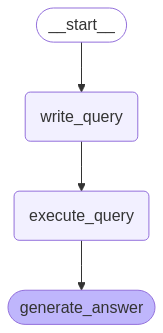

In [32]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [33]:
for step in graph.stream(
    {"question": "How many violations occurred in Texas in 2020?"}, stream_mode='updates'
):
    print(step)

{'write_query': {'query': "SELECT COUNT(*) FROM toxic_emissions WHERE FAC_STATE = 'TX' AND REPORTING_YEAR = 2020"}}
{'execute_query': {'result': '[(6375,)]'}}
{'generate_answer': {'answer': 'Based on the SQL query and result, it appears that there were 6,375 violations of toxic emissions in Texas in 2020.'}}


____

In [ ]:

table_info = db.get_table_info()
top_k = 5
sql_prompt = PromptTemplate.from_template(
    # input_variables = ["input", "table_info", "top_k", "dialect"],
    template=sql_prompt_text
)

sql_agent_prompt = sql_prompt.format(dialect="SQLite", table_info=table_info, top_k=top_k, input="{input}")

sql_agent = create_sql_query_chain(llm, db, prompt=sql_prompt)
# sql_agent

In [19]:
user_input = "What are the top 5 counties by the number of RCRA violations emissions?"
sql_code = sql_agent.invoke({'question': user_input,})
print(sql_code)
print(db.run(sql_code))

SELECT county, COUNT(*) AS rcra_violations_count FROM rcra_violations_emissions GROUP BY county ORDER BY rcra_violations_count DESC LIMIT 5;
[('JEFFERSON', 139), ('MONTGOMERY', 104), ('WASHINGTON', 87), ('DOUGLAS', 85), ('LAKE', 73)]


In [20]:
def sql_query_chain(user_input):
    # system_message = sql_prompt.format(dialect="SQLite", top_k=5, table_info=db.get_table_info(), input=user_input)
    write_sql_query = create_sql_query_chain(llm, db, prompt=sql_prompt)
    execute_sql_query = QuerySQLDataBaseTool(db=db)
    sql_query_chain = write_sql_query | execute_sql_query
    return sql_query_chain.invoke({"question": user_input})
    # agent_executor = create_react_agent(llm, tools=toolkit.get_tools(), prompt=sql_prompt, debug=True)
    # events = agent_executor.stream({'messages': [('user', user_input)]}, stream_mode="values",)
    # for event in events:
    #     return event['messages'][-1].pretty_print()
# user_input = input("Enter your question: ")

print(sql_query_chain(user_input))

[('JEFFERSON', 139), ('MONTGOMERY', 104), ('WASHINGTON', 87), ('DOUGLAS', 85), ('LAKE', 73)]


In [21]:
system_message = sql_prompt.format(dialect="SQLite", top_k=5, table_info=db.get_table_info(), input=user_input)

In [23]:
agent_executor = create_react_agent(llm, tools=toolkit.get_tools(), prompt=system_message, debug=True)
question = "Which 5 counties had the highest number of RCRA violations and what were the totals?"

for step in agent_executor.stream(
    {'messages': [{'role':'user', 'content': question}]},
    stream_mode="values",):
    step['messages'][-1].pretty_print()


# events = agent_executor.stream({'messages': [('user', user_input)]}, stream_mode="values",)
# for event in events:
#     event['messages'][-1].pretty_print()

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [{'content': 'Which 5 counties had the highest number of RCRA '
                          'violations and what were the totals?',
               'role': 'user'}]}
[0:writes] Finished step 0 with writes to 1 channel:
- messages -> [{'content': 'Which 5 counties had the highest number of RCRA violations and '
             'what were the totals?',
  'role': 'user'}]
[0:checkpoint] State at the end of step 0:
{'messages': [HumanMessage(content='Which 5 counties had the highest number of RCRA violations and what were the totals?', additional_kwargs={}, response_metadata={}, id='c34d3f79-5f3d-4f5e-9b30-404d10ab1239')]}
[1:tasks] Starting 1 task for step 1:
- agent -> {'is_last_step': False,
 'messages': [HumanMessage(content='Which 5 counties had the highest number of RCRA violations and what were the totals?', additional_kwargs={}, response_metadata={}, id='c34d3f7

## LANGGRAPH QUICK START

In [ ]:
## Our graph needs to handle two key tasks:
## Each node can receive the current State as input and output an update to the state.
## Updates to messages will be appended to the existing list rather than overwriting it, thanks to the prebuilt add_messages function used with the Annotated syntax.







class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [ ]:
tools = [sql_query_chain]

llm_with_tools = llm.bind_tools(tools)

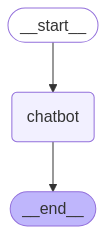

In [ ]:
## Next add a chatbot node. Nodes represent units of work. They are typically regular python functions.
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)
# graph_builder.add_edge(START, 'chatbot')
# graph_builder.add_edge('chatbot', END)

graph = graph_builder.compile()


In [ ]:


try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [4]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: I’m a large language model. When you ask me a question or provide me with a prompt, I analyze what you say and generate a response that is relevant and accurate. I'm constantly learning and improving, so over time I'll be even better at assisting you. Is there anything I can help you with?
Assistant: The infamous US tax code! I'll provide an overview of the current state of the US tax code, but keep in mind that it's a complex and constantly evolving system. Here are some key aspects:

**Structure:**

1. **Internal Revenue Code (IRC):** The IRC is the primary law governing federal taxation in the United States. It consists of 26 chapters, each addressing a specific aspect of taxation.
2. **Tax Laws:** Various tax laws, such as the Tax Cuts and Jobs Act (TCJA) of 2017, have amended the IRC over time.

**Key Components:**

1. **Income Tax:** The US has a progressive income tax system, with seven tax brackets ranging from 10% to 37%.
2. **Tax Brackets:** Taxpayers are classifie